# Compare performances between different experiments

- compare ROC curves / PR curves between e.g. different variable selections or datasets

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/myaReg-genderDifferences"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_preprocess import read_data, subset_wo_missigness, remove_NA, parseVariables, clean_data, impute_scale 
import pickle


from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, auc, PrecisionRecallDisplay



my_pal = {"Development": "forestgreen", "Validation": "gold"}

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


### structure:  varSet: vars
dic_varSets = {  
    "Development":"30_internalValidation/natural/gender_bootstrapped_iterativeBoruta_100perc",
    "Validation":"40_externalValidation/natural",
}

figPublicationPath = f'{PATH}/figures/publication/natural'
os.makedirs(figPublicationPath, exist_ok=True)


In [3]:
#### Merge dataframes to plot

df_all = pd.DataFrame()
for k,v in dic_varSets.items():
    resultsPath = f"{PATH}/results/{v}"
    df = pd.read_csv(f"{resultsPath}/summary_scores.csv", index_col=0)
    df["varSet"] = k
    df_all = pd.concat([df_all, df], axis=0)

df_all = df_all.drop(["brier"], axis=1)

FixedFormatter should only be used together with FixedLocator


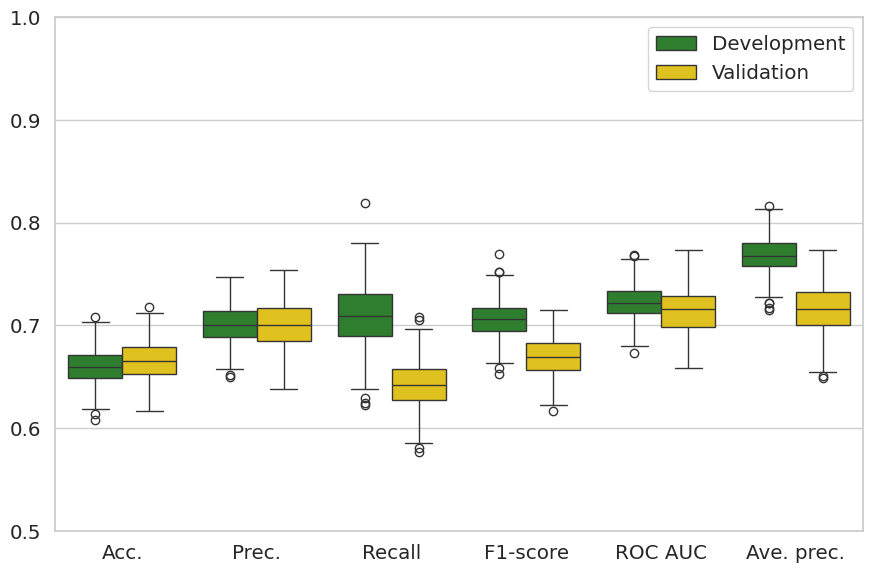

In [4]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, ax1 = plt.subplots(1,1,figsize=(9,6))

tmp = df_all.melt(["varSet"])
sns.boxplot(data=tmp, x= "variable", y="value", hue="varSet", ax=ax1, palette=my_pal)
ax1.set_ylim(0.5,1)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.legend(title='')
ax1.set_xticklabels(["Acc.", "Prec.", "Recall", "F1-score", "ROC AUC", "Ave. prec."])
plt.tight_layout()

fig.savefig(f"{figPublicationPath}/all_scores.png", dpi=300)

# ROC AUC curves

In [5]:
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


### structure:  varSet: vars
dic_varSets = {  
    "Development":"30_internalValidation/natural/gender_bootstrapped_iterativeBoruta_100perc",
    "Validation":"40_externalValidation/natural"   
}


In [6]:
''' Load data for curve 1 '''
n_iter = 300
resultsPath = f"{PATH}/results/{list(dic_varSets.values())[0]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary = pickle.load(f)


''' Load data for curve 2 '''
n_iter = 300
resultsPath = f"{PATH}/results/{list(dic_varSets.values())[1]}"
with open(f'{resultsPath}/bootstrap_validation_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary_c2 = pickle.load(f)



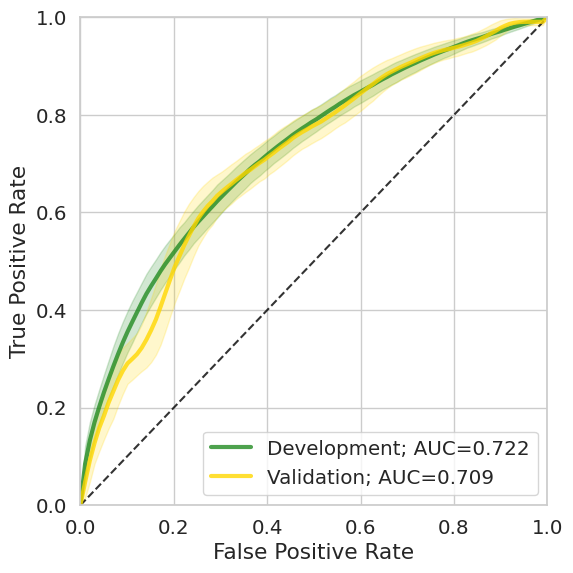

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
mean_fpr = np.linspace(0, 1, 100)


''' Development '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)  #tprs[5]
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color=my_pal["Development"],
    #label=f"Development; AUC=0.828 \n(95%CI 0.763, 0.883)",
    label=f"{list(dic_varSets.keys())[0]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color=my_pal["Development"],
    alpha=0.2,
    label="",
)    


''' Curve 2 '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color=my_pal["Validation"],
    label=f"{list(dic_varSets.keys())[1]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color=my_pal["Validation"],
    alpha=0.2,
    label="",
)     




''' General '''
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black", alpha=.8, zorder=1)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.tight_layout()


plt.savefig(f"{figPublicationPath}/ROC_curves_validation.png", dpi=300)
#plt.savefig(f"{folderFigures}/ROC_curves.pdf", dpi=300)



# PR curve

### Development

In [8]:
''' Load data for curve 1 '''
n_iter = 300
resultsPath = f"{PATH}/results/{list(dic_varSets.values())[0]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary = pickle.load(f)


In [9]:
dataPath = f"{PATH}/data/"
varSet = "natural"
vars = "gender_bootstrapped_iterativeBoruta_100perc"
resultsPath = f"{PATH}/results/30_internalValidation/{varSet}/{vars}"
n_iter = 300

''' 
Split data
'''
devData = read_data(PATH,FILENAME=f"{varSet}")
X = devData.drop(target, axis=1)
y_dev = devData[target]


''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data_dev = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T
y_proba_dev = data_dev.median(axis=1).sort_index()
y_dev = y_dev.loc[y_proba_dev.index] 

precision_dev, recall_dev, _ = precision_recall_curve(y_dev, y_proba_dev)
#average_precision_dev = average_precision_score(y_dev, y_proba_dev)

average_precision_dev = pd.DataFrame.from_dict(dic_summary).T.loc[:,"average_prec"].mean()







LOADING DATA


### Validation

In [10]:

''' Load data for curve 2 '''
n_iter = 300
resultsPath = f"{PATH}/results/{list(dic_varSets.values())[1]}"
with open(f'{resultsPath}/bootstrap_validation_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary_c2 = pickle.load(f)

In [11]:


dataPath = f"{PATH}/data/validation/"
dataset = "natural"
resultsPath = f"{PATH}/results/40_externalValidation/{varSet}"
varFolder = "boruta"

''' 
Variables
'''
with open(f"{PATH}/data/validation/discovery_validation_variables_translation.json", "r") as f: varTranslation = json.load(f)
dutch_varTranslation = {v: k for k, v in varTranslation.items()}

''' 
Read validation data
'''
with open(f"{PATH}/data/validation/validation_dtypes.json", "r") as f:
    dtypes = json.load(f)

data = pd.read_csv(f"{dataPath}/dutch_MG_patients_V2_recoded.csv", index_col=0, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())


''' Only parse variables needed for model '''
variables = pd.read_csv(f"{PATH}/results/20_featureSelection/{dataset}/{varFolder}/gender_bootstrapped_iterativeBoruta_100perc.txt", 
                       header=None)[0].tolist()
variables.append("gender")
variables_dutch = [varTranslation[ele] for ele in variables]
data = data.loc[:,variables_dutch]

''' translate varnames to German registry to fit models! '''
data.columns = [dutch_varTranslation[ele] for ele in data.columns]


''' 
Split
'''
X_val = data.drop(target, axis=1)
y_val = data[target]

''' Load predProba'''
with open(f'{resultsPath}/bootstrap_validation_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T
y_proba = data.median(axis=1).sort_index()
y_val = y_val.loc[y_proba.index] 

precision, recall, _ = precision_recall_curve(y_val, y_proba)
#average_precision = average_precision_score(y_val, y_proba)

average_precision = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"average_prec"].mean()


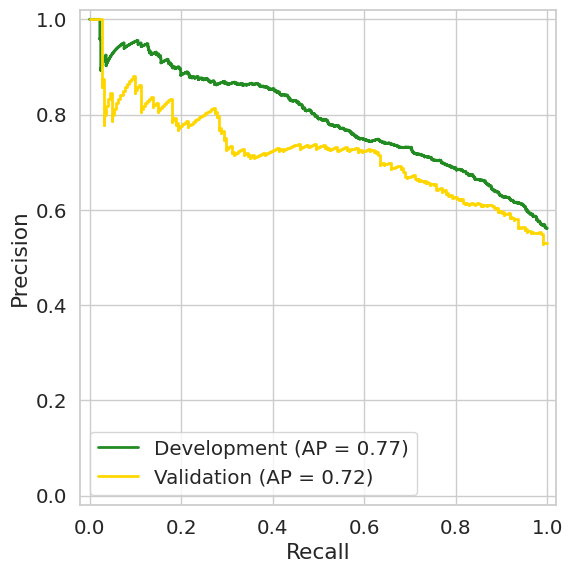

In [12]:
recallList = [recall_dev] + [recall]
precisionList = [precision_dev] + [precision]
average_precisionList = [average_precision_dev] + [average_precision]

sns.set_theme(style="whitegrid", font_scale=1.3)
_, ax = plt.subplots(figsize=(6,6))
for i, color, name in zip(range(2), [my_pal["Development"],my_pal["Validation"]], ["Development", "Validation"]):
    display = PrecisionRecallDisplay(
        recall=recallList[i],
        precision=precisionList[i],
        average_precision=average_precisionList[i],
    )
    display.plot(ax=ax, name=f"{name}", color=color, lw=2)
ax.set_xlim(-0.02,1.02)
ax.set_ylim(-0.02,1.02)
ax.legend()
plt.tight_layout()
plt.savefig(f"{figPublicationPath}/PR_curves_validation.png", dpi=300)
plt.show()